# Product Analysis
based on User Preference

## Purpose
Finding insight on : 
- What is the most likely to be bought product ? 
- What is the top rated product?

## Background
Uncovering purchase pattern of ecommerce user may increase potential purchase when we recommend product to user.

## Assumption
This analysis is done with assumption all user segment is same.


## Sanity Check

In [4]:
import json

def load_config(file_path: str = "./config.json"):
    with open(file_path) as config_file:
        data = json.load(config_file)
    return data

config = load_config("../config.json")
DBNAME = config.get("DBNAME")
HOSTNAME = config.get("HOSTNAME")
USER = config.get("USER")
PASS = config.get("PASS")
SCHEMA = config.get("SCHEMA")

In [5]:
# Basic 
import sys
import numpy as np
import scipy as sp
import pandas as pd

# SQL Engine
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Profiling process
from tqdm import tqdm

# Warning problems in notebook
import warnings
warnings.filterwarnings('ignore')

# Visualization
import bamboolib as bam
import plotly.express as px

# Reporting result
import sweetviz as sv
from dataprep.eda import create_report

In [6]:
# Load data

# Create an engine instance
alchemyEngine = create_engine(
    f'postgresql+psycopg2://{USER}:{PASS}@{HOSTNAME}/{DBNAME}', pool_recycle=3600)

# Connect to PostgreSQL server
conn = alchemyEngine.connect()

schema = SCHEMA

In [7]:
# Init needed data

QUERY = """
-- Data mart no aggregation
select 
	foi.order_id ,
	p.product_id,
	p.product_category,
    foi.price,
	f.feedback_id,
	f.feedback_score
from staging.fct_order_items foi 
left join (
	select 
		dp.product_key ,
		dp.product_id ,
		dp.product_category
	from staging.dim_product dp 
	where dp.is_current_version=true
) p on foi.product_key = p.product_key
left join (
	select 
		df.feedback_key ,
		df.feedback_id ,
		df.feedback_score 
	from staging.dim_feedback df 
	where df.is_current_version=true
) f on foi.feedback_key = f.feedback_key;
"""

df = pd.read_sql_query(QUERY, conn)
df

,order_id,product_id,product_category,price,feedback_id,feedback_score
0,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,health_beauty,145950.0,67b1ab8f3ec19d5a90f153f21757d3a1,1.0
1,000e63d38ae8c00bbcb5a30573b99628,553e0e7590d3116a072507a3635d2877,bed_bath_table,47900.0,06f45fcd8b9b54c30b0de110eb849228,3.0
2,000e906b789b55f64edcb1f84030f90d,57d79905de06d8897872c551bfd09358,telephony,21990.0,a5fb93d6a9e707bd84c07da74e8d79fd,3.0
3,001021efaa8636c29475e7734483457d,5d7c23067ed3fc8c6e699b9373d5890b,fashion_bags_accessories,49000.0,fa2d523cc60173d4889520763a2e4851,4.0
4,0013503b13da1eac686219390b7d641b,38afdf723b95d455b418a0f57d623c6b,furniture_decor,119900.0,b5c9aa83935388c89bd9b1b2ce6d1439,5.0
...,...,...,...,...,...,...
112645,fff60e5408a9dd1e92ee30023052af30,1a405418406359cc2b8815f93bf359c2,sports_leisure,129900.0,b18bbbad8ed93c9dafe7cdbb3e0d5f09,5.0
112646,fff8286f77788ab8b55b2e5747fa7dd8,a2da86fa759178e9e58e54aa1a144e59,telephony,24990.0,04be5443ee0904052de26dcaaf90dff9,4.0
112647,fff90cdcb3b2e6cfb397d05d562fd3fe,764292b2b0f73f77a0272be03fdd45f3,furniture_decor,89900.0,d36aebe5756a7aecd9805954a8533285,5.0
112648,fffb2ef8874127f75b52b643880fd7e0,ebceb9726cf5c6187b48e17fe58747b0,bed_bath_table,17900.0,75dc15ce1ccf026e1c9443a0d94aa183,5.0


In [18]:
df_grouped_category =  df.groupby(['product_category']).agg(order_count=('order_id', 'size'), rating=('feedback_score', 'mean'), revenue=('price', 'sum')).reset_index()
df_grouped_category

,product_category,order_count,rating,revenue
0,OTHER,1627,3.811924,1.850498e+08
1,agro_industry_and_commerce,212,4.000000,7.253047e+07
2,air_conditioning,297,3.919192,5.502496e+07
3,art,209,3.918660,2.420264e+07
4,arts_and_craftmanship,24,4.125000,1.814010e+06
...,...,...,...,...
67,stationery,2517,4.183552,2.309432e+08
68,tablets_printing_image,83,4.048193,7.528410e+06
69,telephony,4545,3.934653,3.236675e+08
70,toys,4117,4.138936,4.839466e+08


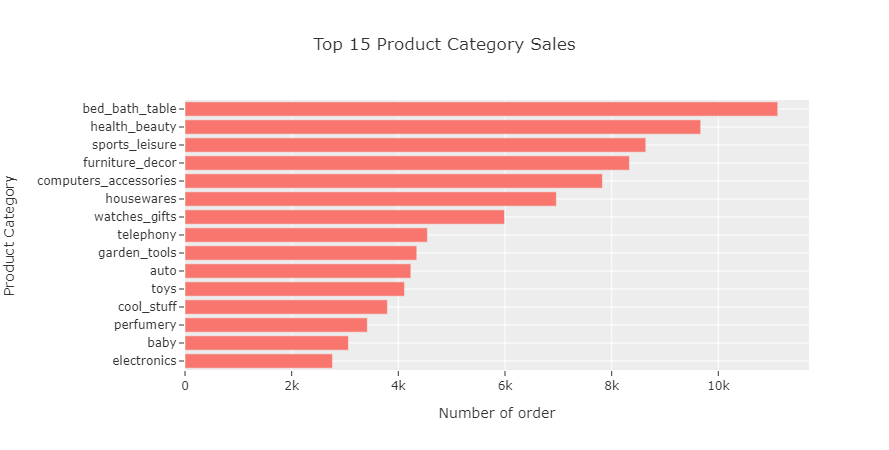

In [20]:
# Top 10 product purchased based on category
df_grouped_category.sort_values(by=['order_count'], 
                                ascending=False, 
                                inplace=True
                               )
fig = px.bar(df_grouped_category.iloc[:15], x='order_count', orientation='h', y='product_category', template='ggplot2', title = "Top 15 Product Category Sales")
fig.update_yaxes(categoryorder='total ascending')
fig.update_yaxes(title='Product Category')
fig.update_xaxes(title='Number of order')
fig

Based on the number of order, we could see that bed_bath_table (furniture) is the most popular item , followed by health_beauty and sports_leisure. 

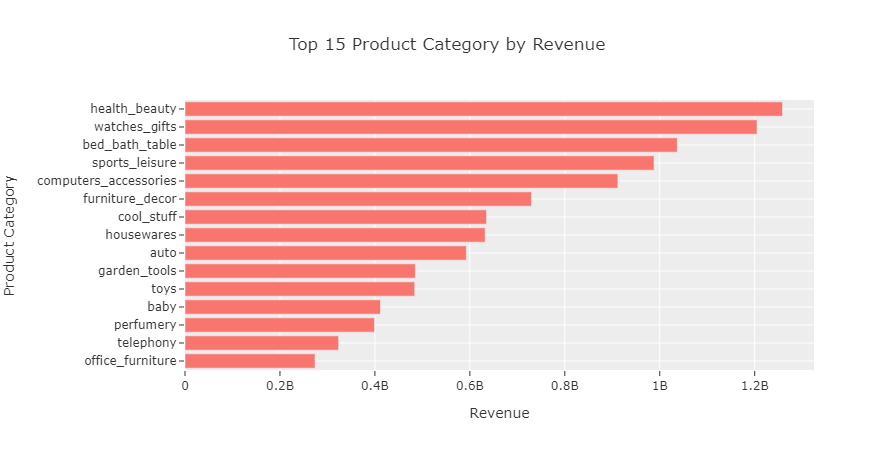

In [14]:
# Top 10 product by revenue
df_grouped_category.sort_values(by=['revenue'], ascending=False, inplace=True)
fig = px.bar(df_grouped_category.iloc[:15], x='revenue', orientation='h', y='product_category', template='ggplot2', title = "Top 15 Product Category by Revenue")
fig.update_yaxes(categoryorder='total ascending')
fig.update_yaxes(title='Product Category')
fig.update_xaxes(title='Revenue')
fig

Based on the revenue, we could see that health_beauty and watches_gift is the most profitable item. It might because those item normally expensive, thus increasing revenue (omzet) for each purchase in the ecommerce

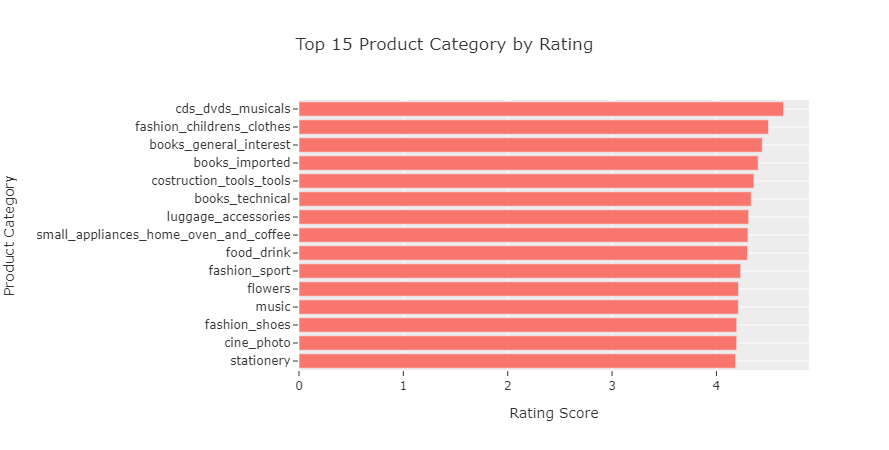

In [13]:
# Top 10 product rated
df_grouped_category.sort_values(by=['rating'], ascending=False, inplace=True)
fig = px.bar(df_grouped_category.iloc[:15], x='rating', orientation='h', y='product_category', template='ggplot2', title = "Top 15 Product Category by Rating")
fig.update_yaxes(categoryorder='total ascending')
fig.update_yaxes(title='Product Category')
fig.update_xaxes(title='Rating Score')
fig

Based on the rating, we could see that cd_dvd_musical is the highest, followed by fashion and book. This might be because item like cd normally

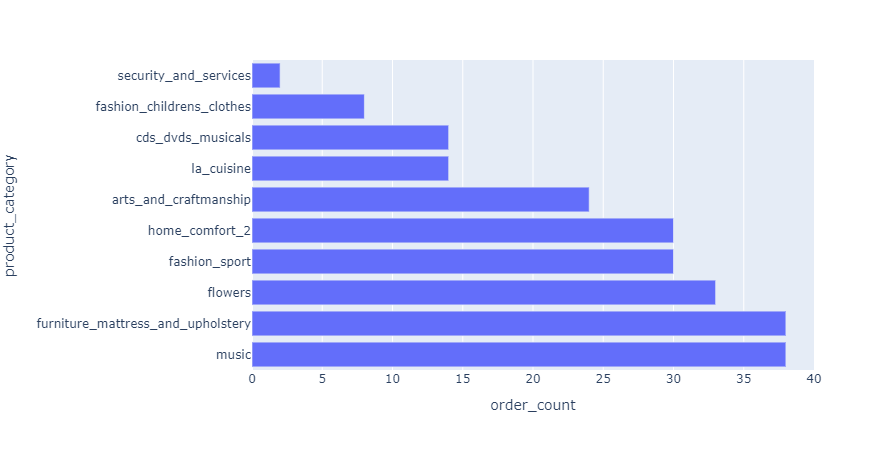

In [23]:
df_grouped_category.sort_values(by=['order_count'], ascending=True, inplace=True)
fig = px.bar(df_grouped_category.iloc[:10], x='order_count', orientation='h', y='product_category')
fig.update_yaxes(categoryorder='total descending')
fig

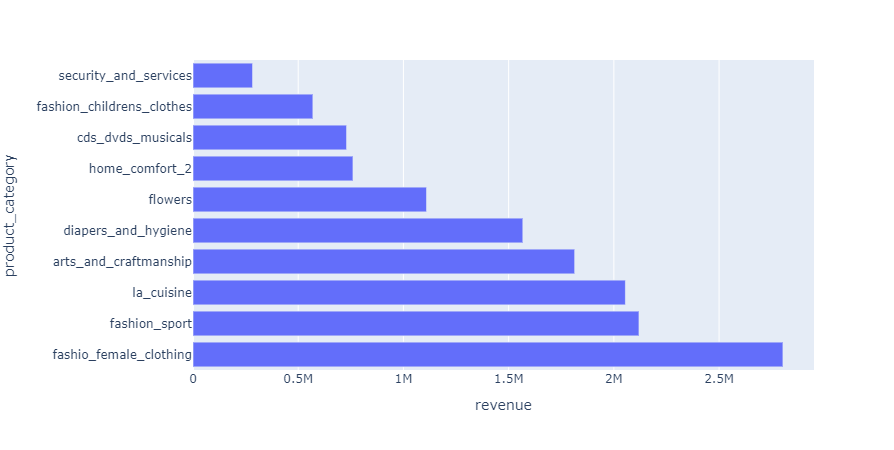

In [24]:
df_grouped_category.sort_values(by=['revenue'], ascending=True, inplace=True)
fig = px.bar(df_grouped_category.iloc[:10], x='revenue', orientation='h', y='product_category')
fig.update_yaxes(categoryorder='total descending')
fig

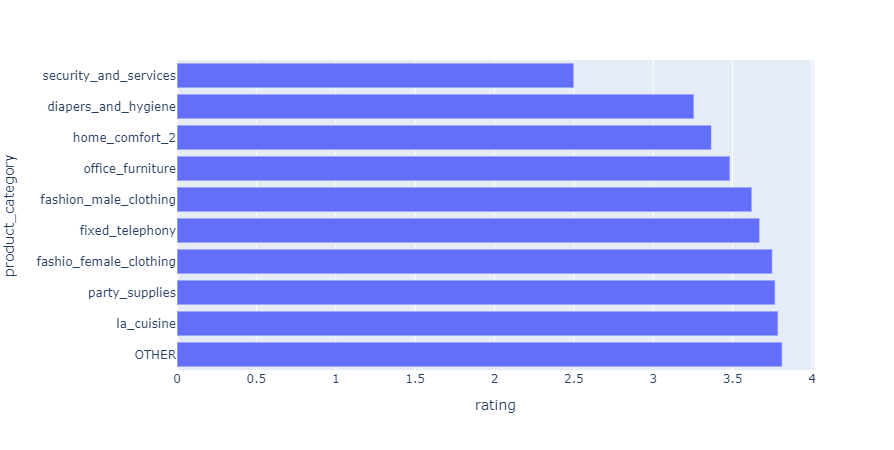

In [25]:
# Bottom 10 product rated
df_grouped_category.sort_values(by=['rating'], ascending=True, inplace=True)
fig = px.bar(df_grouped_category.iloc[:10], x='rating', orientation='h', y='product_category')
fig.update_yaxes(categoryorder='total descending')
fig

In [16]:
QUERY = """
-- Product for each order (each basket in transaction)
select 
	foi.order_id ,
	MAX(foi.total_payment_value) as payment_val,
	STRING_AGG(p.product_id::character varying, ',') as list_of_item,
	STRING_AGG(distinct p.product_category::character varying, ',') as list_of_category
from staging.fct_order_items foi 
left outer join (
	select 
		dp.product_key ,
		dp.product_id ,
		dp.product_category 
	from staging.dim_product dp 
	where dp.is_current_version=true
) p on foi.product_key = p.product_key
group by 1;
"""

agg_df = pd.read_sql_query(QUERY, conn)
agg_df

,order_id,payment_val,list_of_item,list_of_category
0,00010242fe8c5a6d1ba2dd792cb16214,72190.0,4244733e06e7ecb4970a6e2683c13e61,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,259830.0,e5f2d52b802189ee658865ca93d83a8f,pet_shop
2,000229ec398224ef6ca0657da4fc703e,216870.0,c777355d18b72b67abbeef9df44fd0fd,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,25780.0,7634da152a4610f1595efa32f14722fc,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,218040.0,ac6c3623068f30de03045865e4e10089,garden_tools
...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,343400.0,4aa6014eceb682077f9dc4bffebc05b0,housewares
98662,fffcd46ef2263f404302a634eb57f7eb,386530.0,32e07fd915822b0765e448c4dd74c828,computers_accessories
98663,fffce4705a9662cd70adb13d4a31832d,116850.0,72a30483855e2eafc67aee5dc2560482,sports_leisure
98664,fffe18544ffabc95dfada21779c9644f,64710.0,9c422a519119dcad7575db5af1ba540e,computers_accessories


## Insight

## Recommendation

## Reference